In [6]:
# bayes classifier over emotion dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from lib.dataset_utils import *
from sklearn.pipeline import Pipeline
from lib.plot_utils import plot_multilabel_confusion_heatmap, plot_score_barplot
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
import string

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
DATASET = DatasetEnum.GoEmotionsCleaned
# load dataset
train_df, val_df, test_df = load_dataset(DATASET)
LABELS = train_df.columns[1:]
TEXT_COLUMN = 'text'

In [3]:
def OVA_bayes(fit_df, predict_df, classifier, text_col, label_cols):
    predictions_test = []
    predictions_train = []
    for emotion in label_cols:
        classifier.fit(fit_df[text_col], fit_df[emotion])
        # add column to predictions
        predictions_test.append(classifier.predict(predict_df[text_col]))
        predictions_train.append(classifier.predict(fit_df[text_col]))
    # convert to numpy array column wise
    predictions_test = np.array(predictions_test).T
    predictions_train = np.array(predictions_train).T
    return predictions_train, predictions_test
    
def bayes_analysis(train_df, val_df, classifier, text_col, label_cols):
    # train classifier
    predictions_train, predictions_val = OVA_bayes(train_df, val_df, classifier, text_col, label_cols)
    # calculate metrics
    print("Train metrics")
    print(classification_report(train_df[label_cols], predictions_train, target_names=label_cols, zero_division=0))
    print("Val metrics")
    print(classification_report(val_df[label_cols], predictions_val, target_names=label_cols, zero_division=0))
    # plot confusion matrix
    print("Train confusion matrix")
    plot_multilabel_confusion_heatmap(train_df[label_cols].to_numpy(), predictions_train, label_cols, label_cols, normalize=True)
    print("Val confusion matrix")
    plot_multilabel_confusion_heatmap(val_df[label_cols].to_numpy(), predictions_val, label_cols, label_cols, normalize=True)
    # bar plot over classes
    plot_score_barplot(train_df[label_cols], predictions_train, label_cols)
    plot_score_barplot(val_df[label_cols], predictions_val, label_cols)

In [7]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
def clean_content(text):
    
    # convert to lowercase
    clean_text = text.lower()
    
    # tokenize
    clean_text = nltk.word_tokenize(clean_text)

    # lemmatize and remove punctuation marks
    clean_text = [lemmatizer.lemmatize(word) for word in clean_text if word not in string.punctuation]

    return ' '.join(clean_text)

def clean_df(df, text_col, out_col):
    df[out_col] = df[text_col].apply(clean_content)
    return df

In [8]:
CLEAN_TEXT_COLUMN = 'clean_text'
train_df = clean_df(train_df, TEXT_COLUMN, CLEAN_TEXT_COLUMN)
val_df = clean_df(val_df, TEXT_COLUMN, CLEAN_TEXT_COLUMN)

In [5]:
# training one versus rest classifier
NB_classifier = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

In [ ]:
bayes_analysis(train_df, val_df, NB_classifier, TEXT_COLUMN, LABELS)

## Testing Bayes with normalized text

In [ ]:
NB_classifier = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', MultinomialNB())
])
bayes_analysis(train_df, val_df, NB_classifier, CLEAN_TEXT_COLUMN, LABELS)

## Test add k

In [ ]:
NB_classifier = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', MultinomialNB(alpha=0.1))
])
bayes_analysis(train_df, val_df, NB_classifier, CLEAN_TEXT_COLUMN, LABELS)

Add one smoothing is too much, decreasing it offered an improvement of performances

Train metrics
                precision    recall  f1-score   support

    admiration       0.84      0.78      0.81      4130
     amusement       0.89      0.89      0.89      2328
   disapproval       0.79      0.58      0.67      2022
       disgust       0.89      0.75      0.81       793
 embarrassment       0.94      0.80      0.86       303
    excitement       0.75      0.68      0.71       853
          fear       0.90      0.81      0.86       596
     gratitude       0.92      0.93      0.93      2662
         grief       0.81      0.75      0.78        77
           joy       0.79      0.74      0.76      1452
          love       0.89      0.86      0.88      2086
   nervousness       0.92      0.74      0.82       164
         anger       0.85      0.73      0.79      1567
      optimism       0.82      0.75      0.79      1581
         pride       0.88      0.70      0.78       111
   realization       0.82      0.63      0.71      1110
        relief       0.90      0.

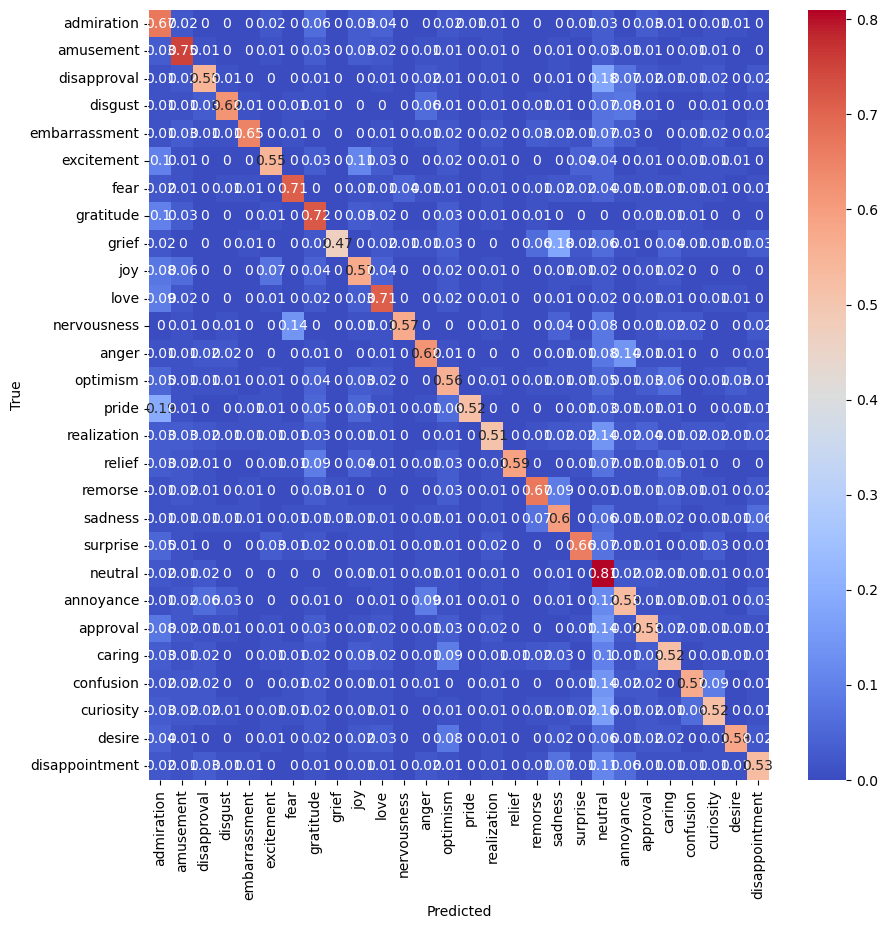

Val confusion matrix


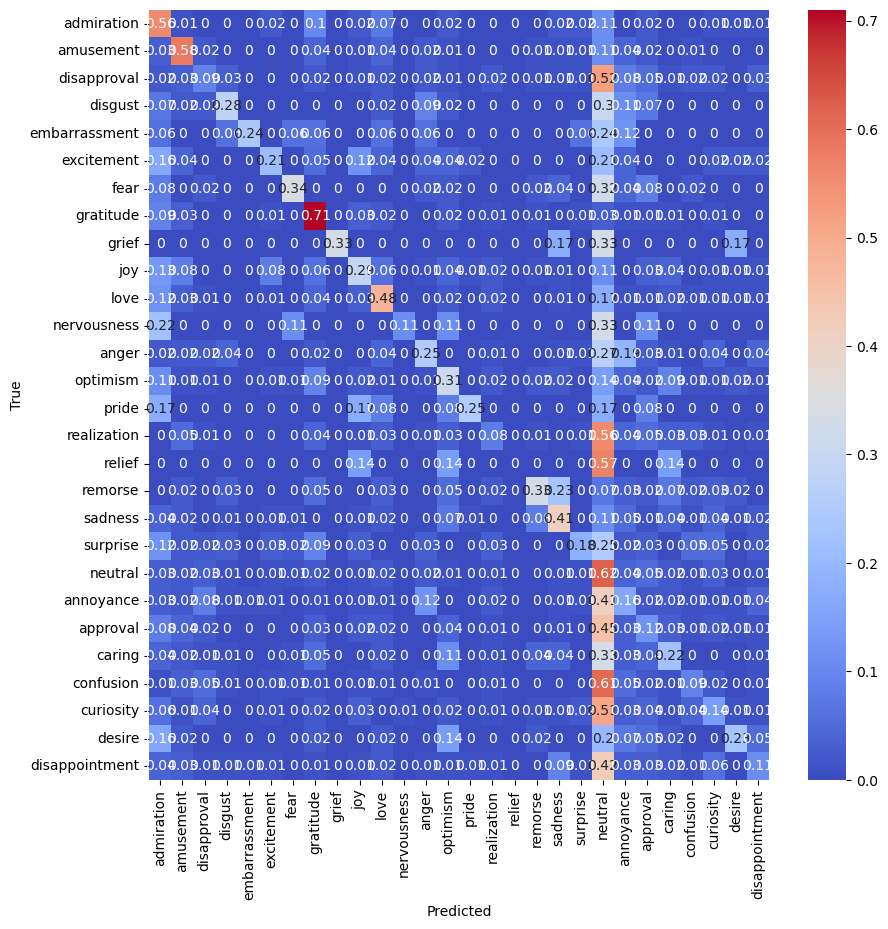

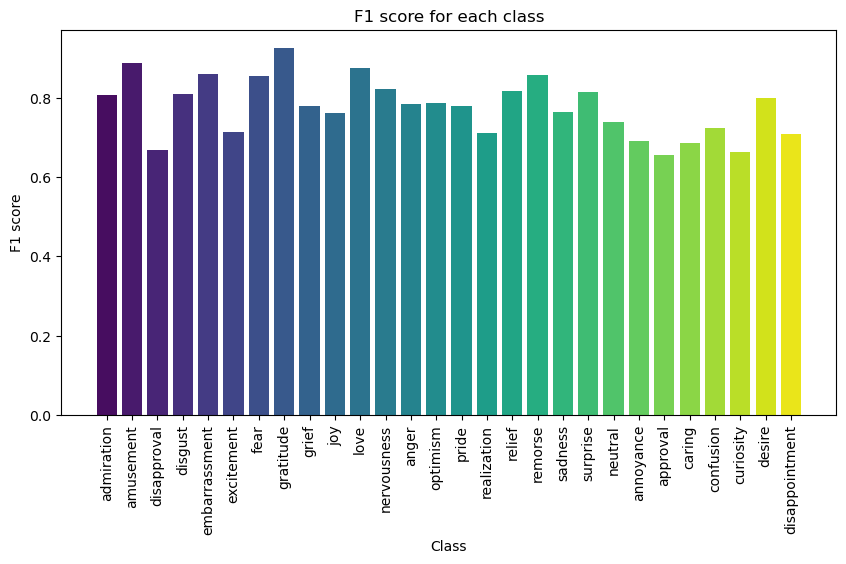

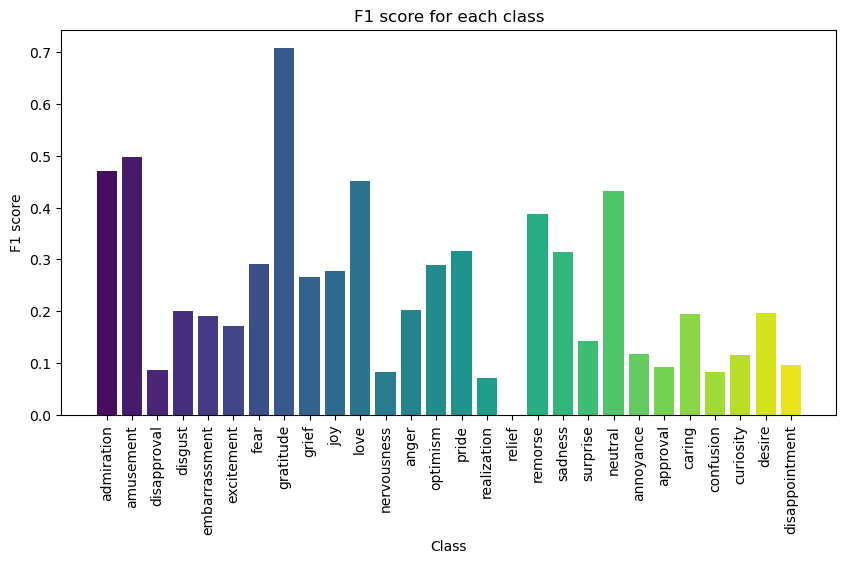

In [7]:
NB_classifier = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', BernoulliNB(alpha=0.01))
])
bayes_analysis(train_df, val_df, NB_classifier, CLEAN_TEXT_COLUMN, LABELS)

Removing stopwords yealds worse performances

Train metrics
                precision    recall  f1-score   support

    admiration       0.78      0.81      0.80      4130
     amusement       0.88      0.89      0.88      2328
   disapproval       0.74      0.61      0.67      2022
       disgust       0.87      0.76      0.81       793
 embarrassment       0.92      0.81      0.86       303
    excitement       0.70      0.72      0.71       853
          fear       0.90      0.83      0.86       596
     gratitude       0.85      0.94      0.89      2662
         grief       0.80      0.82      0.81        77
           joy       0.77      0.75      0.76      1452
          love       0.87      0.87      0.87      2086
   nervousness       0.87      0.76      0.81       164
         anger       0.82      0.76      0.79      1567
      optimism       0.75      0.77      0.76      1581
         pride       0.89      0.76      0.82       111
   realization       0.77      0.64      0.70      1110
        relief       0.88      0.

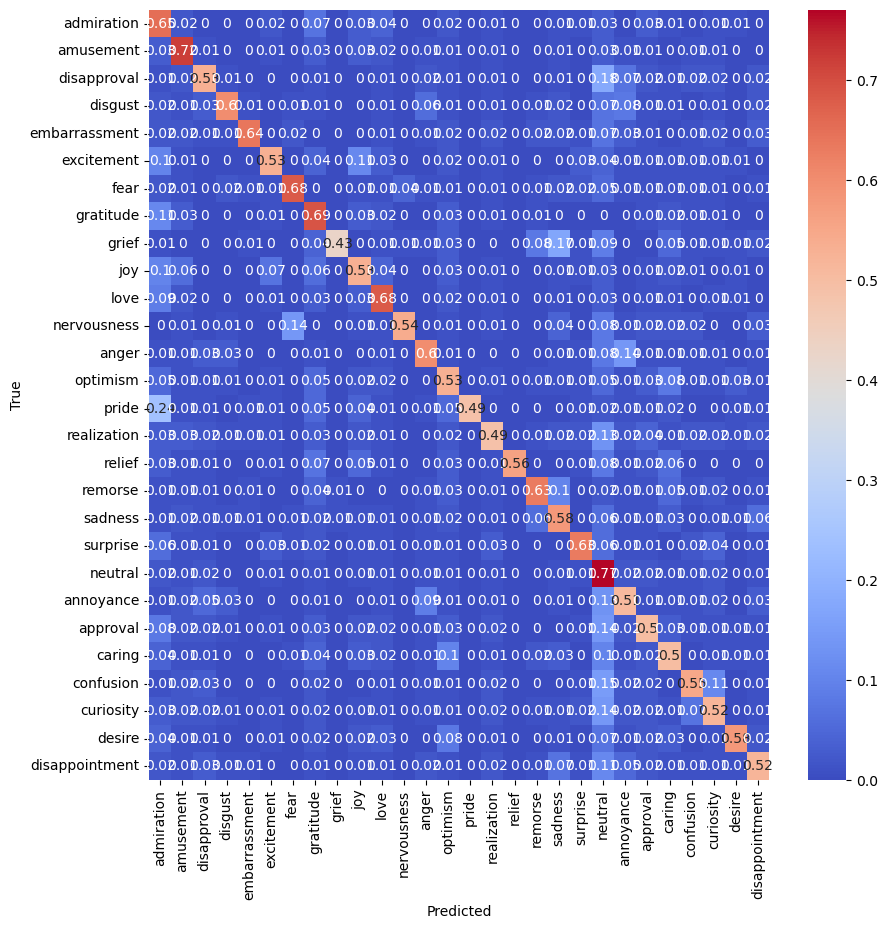

Val confusion matrix


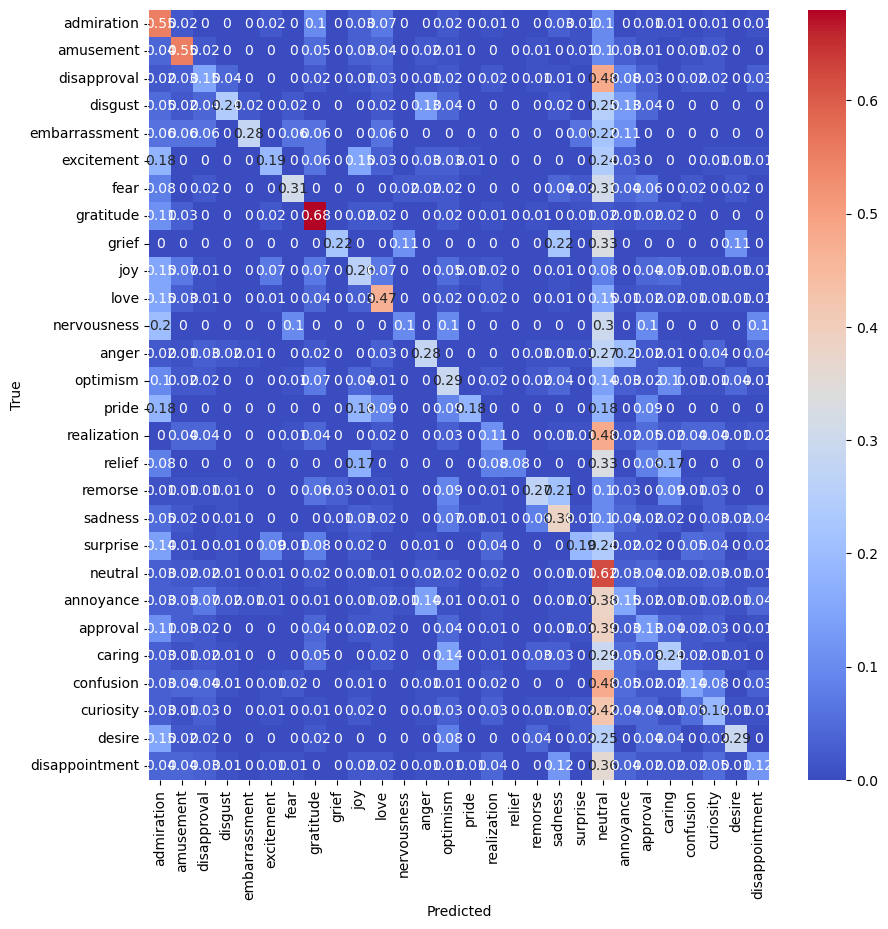

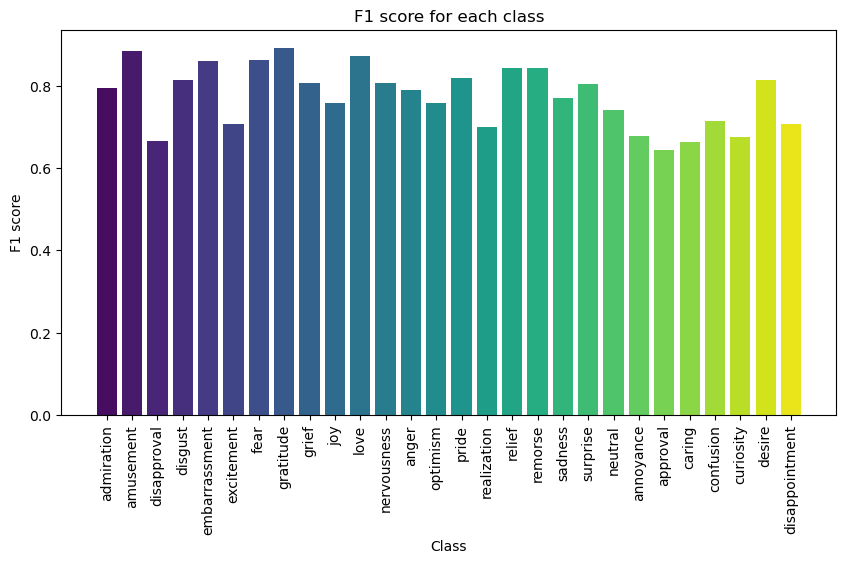

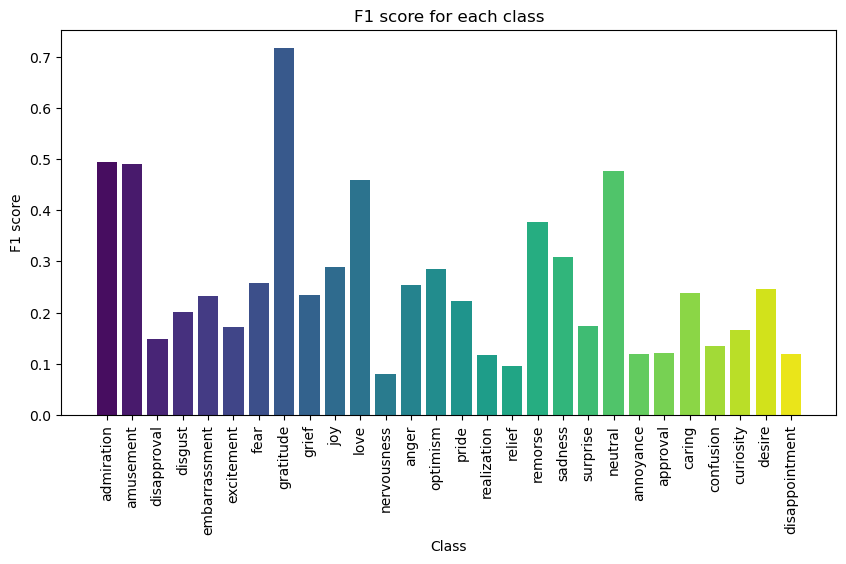

In [9]:
NB_classifier = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', BernoulliNB(alpha=0.01))
])
bayes_analysis(train_df, val_df, NB_classifier, CLEAN_TEXT_COLUMN, LABELS)